 Calculating mean LST within 50m (~164 ft) buffer around each building...


100%|████████████████████████████████████████████████████████████████████████████| 17840/17840 [06:27<00:00, 46.04it/s]


 LST values attached.
 Running landcover zonal stats...
 Landcover composition added.
 Model trained.



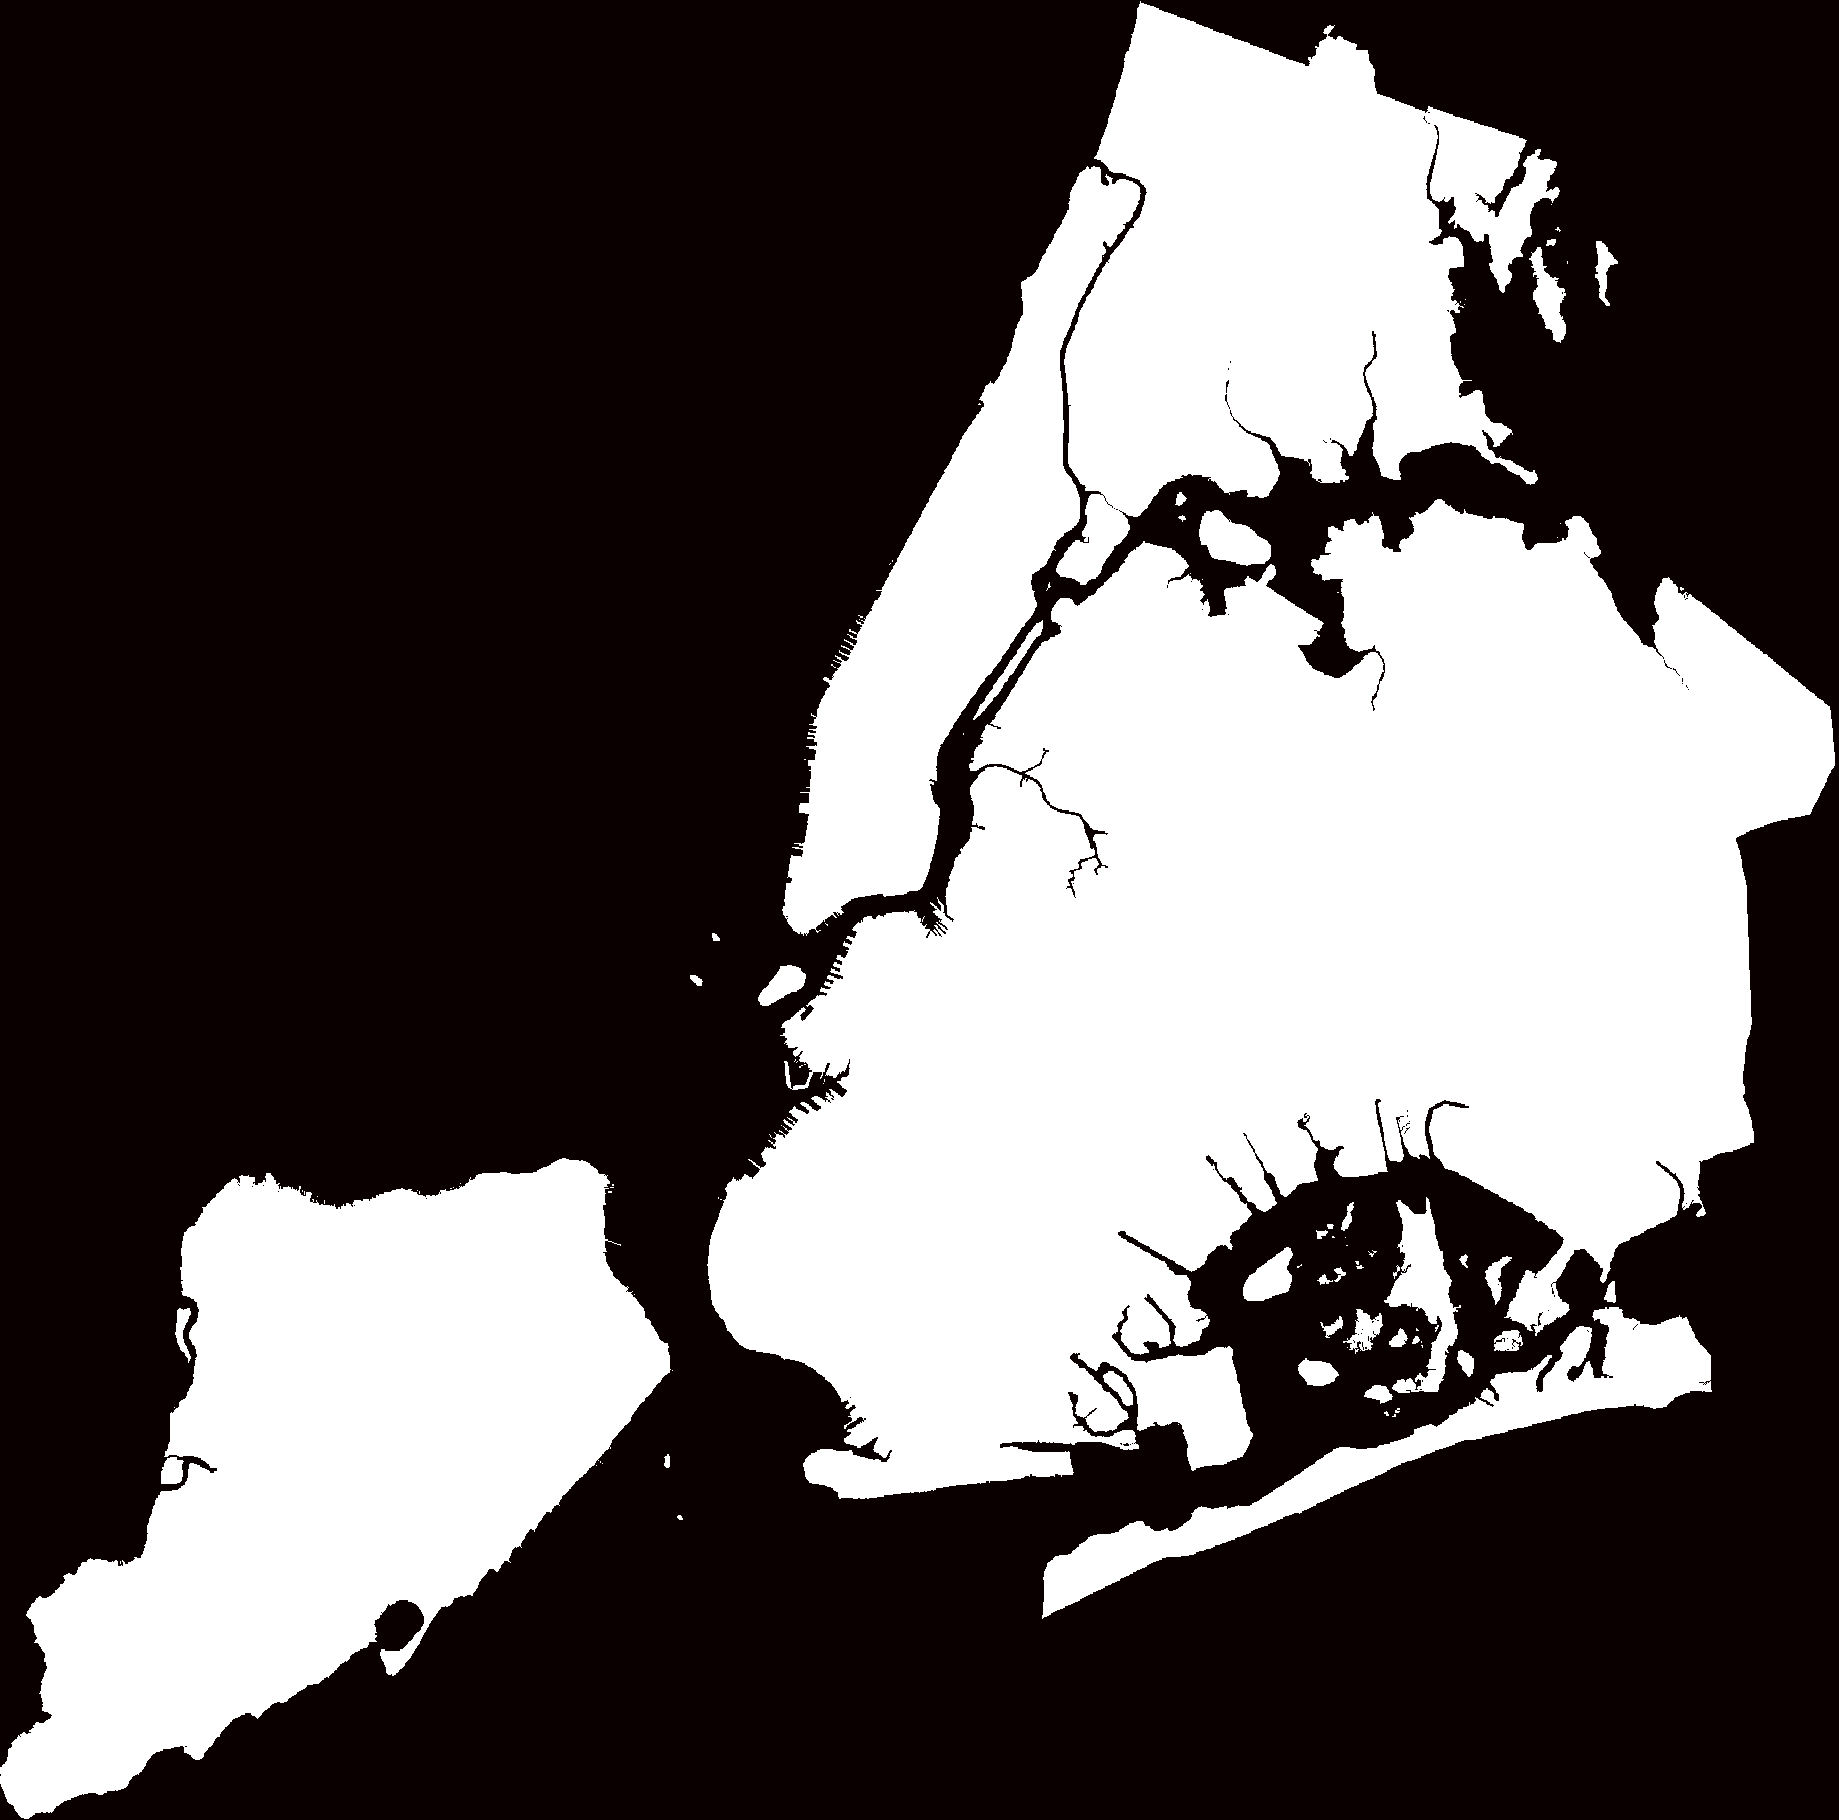

In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from rasterstats import zonal_stats
import folium
from tqdm import tqdm
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import matplotlib.pyplot as plt
from rasterio.plot import show
from folium.raster_layers import ImageOverlay

# Set file paths
BUILDING_SHP_PATH = r'C:\Users\Lino Sanchez\Downloads\truncated_NYC_buildings.shp'
GREEN_ROOF_SHP_PATH = r'C:\Users\Lino Sanchez\Downloads\GreenRoofData2016_20180917_Shapefile\GreenRoofData2016_20180917.shp'
LANDCOVER_RASTER_PATH = r'C:\Users\Lino Sanchez\Downloads\landcover_nyc_2021_10ft.tif'
LST_RASTER_PATH_ORIGINAL = r'C:\Users\Lino Sanchez\Downloads\f_mean_temp.tif'
LST_RASTER_REPROJECTED = r'C:\Users\Lino Sanchez\Downloads\f_mean_temp_reprojected_2263.tif'

# Reproject the LST raster to match building CRS (EPSG:2263)
with rasterio.open(LST_RASTER_PATH_ORIGINAL) as src:
    dst_crs = 'EPSG:2263'
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(LST_RASTER_REPROJECTED, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear)

# Load spatial data
buildings = gpd.read_file(BUILDING_SHP_PATH)
buildings = buildings[~buildings.geometry.is_empty]
buildings = buildings[buildings.geometry.is_valid]

green_roofs = gpd.read_file(GREEN_ROOF_SHP_PATH)

# Ensure CRS consistency
buildings = buildings.to_crs(epsg=2263)
green_roofs = green_roofs.to_crs(epsg=2263)

# Tag buildings that intersect green roofs
joined = gpd.sjoin(buildings, green_roofs, how='left', predicate='intersects')
green_roof_flags = ~joined['index_right'].isna()
green_roof_flags = green_roof_flags.groupby(joined.index).any()
buildings['green_roof'] = buildings.index.map(green_roof_flags).fillna(False)

# Rename columns and drop missing
buildings = buildings.rename(columns={
    'area': 'roof_area',
    'heightroof': 'height'
})
buildings = buildings.dropna(subset=['roof_area', 'height'])

#Filter buildings by area
buildings = buildings[buildings['roof_area'] > 1000]

buildings.to_file(r'C:\Users\Lino Sanchez\Downloads\truncated_NYC_buildings.shp')

# Compute mean LST using 50m buffer (~164 feet) around each building
print(" Calculating mean LST within 50m (~164 ft) buffer around each building...")
lst_means = []

for geom in tqdm(buildings.geometry.buffer(164), total=len(buildings)):
    try:
        stat = zonal_stats([geom], LST_RASTER_REPROJECTED, stats=['mean'], nodata=-9999)[0]
        lst_means.append(stat['mean'])
    except:
        lst_means.append(None)

buildings['lst_mean'] = lst_means

# Remove absurd LST values (e.g., < 0 or > 100°C)
buildings = buildings[(buildings['lst_mean'] > 0) & (buildings['lst_mean'] < 100)]

buildings = buildings.dropna(subset=['lst_mean'])
print(" LST values attached.")

# Extract landcover composition within 50m buffer
print(" Running landcover zonal stats...")
buffers = buildings.geometry.buffer(164)
landcover_stats = zonal_stats(buffers, LANDCOVER_RASTER_PATH, categorical=True, nodata=0)

def compute_percent(stats_dict, code_list):
    total = sum(stats_dict.values())
    selected = sum(stats_dict.get(c, 0) for c in code_list)
    return (selected / total) * 100 if total > 0 else 0

buildings['pct_canopy'] = [compute_percent(d, [1]) for d in landcover_stats]
buildings['pct_grass'] = [compute_percent(d, [2]) for d in landcover_stats]
buildings['pct_impervious'] = [compute_percent(d, [5,6,7,8]) for d in landcover_stats]
print(" Landcover composition added.")

# Drop infinite and absurd values
buildings = buildings[np.isfinite(buildings['lst_mean'])]  # removes inf and -inf

# Clean up bad LST values and remove rows with NaNs or infs in predictors
buildings = buildings.replace([np.inf, -np.inf], np.nan).dropna()

# 9. Train model to predict LST
buildings['green_roof'] = buildings['green_roof'].astype(int)
features = buildings[['green_roof', 'roof_area', 'height', 'pct_canopy', 'pct_grass', 'pct_impervious']]
labels = buildings['lst_mean']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, labels)
print(" Model trained.")

# Precompute cooling effects for all non-green buildings
non_green = buildings[buildings['green_roof'] == 0].copy()
cooling_effects = []

for _, row in non_green.iterrows():
    simulated = row.copy()
    simulated['green_roof'] = 1

    X_sim = pd.DataFrame([{
        'green_roof': simulated['green_roof'],
        'roof_area': simulated['roof_area'],
        'height': simulated['height'],
        'pct_canopy': simulated['pct_canopy'],
        'pct_grass': simulated['pct_grass'],
        'pct_impervious': simulated['pct_impervious']
    }])

    predicted_lst = model.predict(X_sim)[0]
    current_lst = row['lst_mean']
    effect = current_lst - predicted_lst
    cooling_effects.append(effect)

non_green['cooling_effect'] = cooling_effects

# Add display column
non_green['cooling_display'] = [
    f"{v:.2f} °C" if v >= 0 else "Green roof cooling negligible"
    for v in non_green['cooling_effect']
]

# Now reproject after adding all columns
buildings_latlon = buildings.to_crs(epsg=4326)
non_green_latlon = non_green.to_crs(epsg=4326)


# Drop only datetime columns (do NOT drop object/string columns like 'cooling_display')
for df in [buildings_latlon, non_green_latlon]:
    datetime_cols = [col for col in df.columns if pd.api.types.is_datetime64_any_dtype(df[col])]
    df.drop(columns=datetime_cols, inplace=True)

# Create folium map
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=13, tiles="CartoDB positron")

# Normalize raster to 0–255 for PNG image
with rasterio.open(LST_RASTER_REPROJECTED) as src:
    lst_data = src.read(1).astype(float)
    lst_data[lst_data == -9999] = np.nan
    bounds = src.bounds
    extent = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

    norm = (lst_data - np.nanmin(lst_data)) / (np.nanmax(lst_data) - np.nanmin(lst_data))
    plt.imsave("lst_overlay.png", norm, cmap='hot')

# Add raster image overlay to map
folium.raster_layers.ImageOverlay(
    name="LST Heatmap",
    image="lst_overlay.png",
    bounds=extent,
    opacity=0.5,
    interactive=True,
    cross_origin=False,
    zindex=1
).add_to(m)

# Add green roof buildings
folium.GeoJson(
    buildings_latlon[buildings_latlon['green_roof'] == 1],
    name="Green Roofs",
    style_function=lambda feature: {
        'fillColor': 'green',
        'color': 'green',
        'weight': 0.5,
        'fillOpacity': 0.4
    }
).add_to(m)

# Add non-green buildings with popup for simulated cooling effect
for _, row in non_green_latlon.iterrows():
    popup_html = (
        f"<b>Building ID:</b> {row.name}<br>"
        f"<b>Height:</b> {row['height']:.1f} ft<br>"
        f"<b>Roof Area:</b> {row['roof_area']:.0f} ft²<br>"
        #f"<b>Cooling if green roof:</b> {row['cooling_effect']:.2f} °C"
        f"<b>Cooling if green roof:</b> {row['cooling_display']}"

    )
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature: {
            'fillColor': 'gray',
            'color': 'gray',
            'weight': 0.5,
            'fillOpacity': 0.5
        },
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display map
m

In [8]:
import os
os.getcwd()

'C:\\Users\\Lino Sanchez'